In [1]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans

lines = ["Bima1", "Kolf2", "Kolf3", "Kucg2", "Letw5", "Podx1", "Qolg1", "Sojd3", "Wibj2", "Yoch6"]

DE_genes=pd.read_csv('RNA_counts/DE_hiPSC.csv', index_col=0)
DE_genes=DE_genes.drop(['sum_filters'], axis=1)
TPMs = pd.read_csv('RNA_counts/TPMS_hiPSC.csv').iloc[:,0:22]
TPMs=TPMs.rename(columns={"Unnamed: 0": "geneid"})

RNA_means=pd.DataFrame(columns=["geneid","Bima1", "Kolf2", "Kolf3", "Kucg2", "Letw5", "Podx1", "Qolg1", "Sojd3", "Wibj2", "Yoch6"])
ind=0
for gene in DE_genes.geneid:
    RNA_means.loc[ind,"geneid"]=gene
    for line in lines:
        if line=="Yoch6": #This is Yoch6
            RNA_means.loc[ind,line]=(TPMs[TPMs.geneid==gene][line+"r1"].values+TPMs[TPMs.geneid==gene][line+"r2"].values+TPMs[TPMs.geneid==gene][line+"r3"].values)/3
        else:
            RNA_means.loc[ind,line]=(TPMs[TPMs.geneid==gene][line+"r1"].values+TPMs[TPMs.geneid==gene][line+"r2"].values)/2
    ind=ind+1

DE_genes=pd.merge(DE_genes, RNA_means, on="geneid")


In [ ]:
# Functions to consolidate the data across cell lines and marks
# Both for trainig data and test data

In [2]:
def consolidate_data_glength(mark,annot, lines, delta_length):
    df_lines=DE_bin_train.geneid
    for line in lines:
        filename=mark+"\\"+mark+"_"+line+"_"+annot+".dat"
        data_line=pd.read_csv(filename, sep='\t', header=None, lineterminator='\n')
        data_line=data_line.drop([0], axis=1)
        data_line=data_line.rename(columns={1: "geneid", 2: line})
        data_line=pd.merge(data_line, genelength,on="geneid", how="inner")
        data_line.loc[:,line]=data_line.loc[:,line]/(data_line.loc[:,"glength"]-delta_length)
        df_lines=pd.merge(df_lines,data_line[["geneid",line]], on="geneid", how="left")
    df_lines.to_csv('SVM/DE_genes_'+mark+'_'+annot+'SVM9.csv', index=False)

In [3]:
def consolidate_data(mark,annot, lines, length):
    df_lines=DE_bin_train.geneid
    for line in lines:
        filename=mark+"\\"+mark+"_"+line+"_"+annot+".dat"
        data_line=pd.read_csv(filename, sep='\t', header=None, lineterminator='\n')
        data_line=data_line.drop([0], axis=1)
        data_line=data_line.rename(columns={1: "geneid", 2: line})
        data_line.loc[:,line]=data_line.loc[:,line]/length
        df_lines=pd.merge(df_lines,data_line[["geneid",line]], on="geneid", how="left")
    df_lines.to_csv('SVM/DE_genes_'+mark+'_'+annot+'SVM9.csv', index=False)

In [4]:
def consolidate_data_test(genes_test,marks,annots, line, genelen, length):
    for i in range(len(marks)):
        filename=marks[i]+"\\"+marks[i]+"_"+line+"_"+annots[i]+".dat"
        data_line=pd.read_csv(filename, sep='\t', header=None, lineterminator='\n')
        data_line=data_line.drop([0], axis=1)
        colname=marks[i]+annots[i]
        data_line=data_line.rename(columns={1: "geneid", 2: colname})
        if genelen[i]==0:
            data_line.loc[:,colname]=data_line.loc[:,colname]/length[i]
        else:
            data_line=pd.merge(data_line, genelength,on="geneid", how="inner")
            data_line.loc[:,colname]=data_line.loc[:,colname]/(data_line.loc[:,"glength"]-length[i])
        genes_test=pd.merge(genes_test,data_line[["geneid",colname]], on="geneid", how="left")
    return(genes_test)

In [5]:
genelength=pd.read_csv('genelength.csv')
genelength=genelength[['geneid','glength']]

In [ ]:
# Preparing the data for the SVM and training for each test line.

In [6]:
import main_funcs
import sklearn

lines = ["Bima1", "Kolf2", "Kolf3", "Kucg2", "Letw5", "Podx1", "Qolg1", "Sojd3", "Wibj2", "Yoch6"]
marks=['K9me3', 'K27me3', 'K4me3', 'K4me3','K4me3','ATAC', 'ATAC', 'ATAC']
annots=['gene', 'gene', 'gene', 'prompm1k','tx_pm1k','gene', 'prompm1k', 'tx_pm1k']
genelen=[1,1, 1, 0,0,1, 0, 0]
lengths=[0, 0, 0, 2000,2000,0, 2000, 2000]
epig_vars=['K4', 'K9', 'K27', 'ATAC']

#Seed initialisation for Kmeans
np.random.seed(34601)

#Cycle over all cell lines to test all of them from the other 9
for test_line in lines:
    #Binarise transcription for the training data and assign a binarisation to the test data (ground truth).
    training_lines=lines.copy()
    training_lines.remove(test_line)
    DE_bin_train, test_ground_truth=main_funcs.binarize_test(DE_genes,training_lines, test_line)
    genes_test=DE_bin_train.geneid
    #Prepare data and save to file.
    consolidate_data_glength('K9me3','gene', training_lines, 0)
    consolidate_data_glength('K27me3','gene', training_lines,0)
    consolidate_data_glength('K4me3','gene',training_lines, 0)
    consolidate_data('K4me3','prompm1k',training_lines, 2000)
    consolidate_data('K4me3','tx_pm1k',training_lines, 2000)
    consolidate_data_glength('ATAC','gene',training_lines, 0)
    consolidate_data('ATAC','prompm1k',training_lines, 2000)
    consolidate_data('ATAC','tx_pm1k', training_lines,2000)
    genes_test=consolidate_data_test(genes_test,marks,annots, test_line, genelen, lengths)
    genes_test['K4']=genes_test[['K4me3gene','K4me3prompm1k','K4me3tx_pm1k']].apply(max, axis=1)
    genes_test['ATAC']=genes_test[['ATACgene','ATACprompm1k','ATACtx_pm1k']].apply(max, axis=1)
    genes_test['K9']=genes_test['K9me3gene']
    genes_test['K27']=genes_test['K27me3gene']
    #Load from file and preparing the data for the SVM
    intensities_K4 = pd.read_csv('SVM/DE_genes_K4me3_geneSVM9.csv')
    intensities_K4_tx = pd.read_csv('SVM/DE_genes_K4me3_tx_pm1kSVM9.csv')
    intensities_K4_promoters = pd.read_csv('SVM/DE_genes_K4me3_prompm1kSVM9.csv')
    intensities_K4_pm1k = np.maximum(intensities_K4_tx, intensities_K4_promoters)
    intensities_K4 = np.maximum(intensities_K4, intensities_K4_pm1k)
    intensities_K4 = pd.DataFrame(intensities_K4, columns=intensities_K4.columns, index=intensities_K4.index)
    intensities_K9 = pd.read_csv('SVM/DE_genes_K9me3_geneSVM9.csv')
    intensities_K27 = pd.read_csv('SVM/DE_genes_K27me3_geneSVM9.csv')
    intensities_ATAC = pd.read_csv('SVM/DE_genes_ATAC_geneSVM9.csv')
    intensities_ATAC_tx = pd.read_csv('SVM/DE_genes_ATAC_tx_pm1kSVM9.csv')
    intensities_ATAC_promoters = pd.read_csv('SVM/DE_genes_ATAC_prompm1kSVM9.csv')
    intensities_ATAC_pm1k = np.maximum(intensities_ATAC_tx, intensities_ATAC_promoters)
    intensities_ATAC = np.maximum(intensities_ATAC, intensities_ATAC_pm1k)
    intensities_ATAC = pd.DataFrame(intensities_ATAC, columns=intensities_ATAC.columns, index=intensities_ATAC.index)
    vars = pd.DataFrame(columns=['geneid', 'line', 'K4', 'K9', 'K27', 'ATAC', 'expression'])
    for line in training_lines:
        for gene in DE_bin_train['geneid']:
            vars.loc[len(vars)] = [gene, line, intensities_K4.loc[intensities_K4['geneid'] == gene, line].values[0], 
                                   intensities_K9.loc[intensities_K9['geneid'] == gene, line].values[0], 
                                   intensities_K27.loc[intensities_K27['geneid'] == gene, line].values[0], 
                                   intensities_ATAC.loc[intensities_ATAC['geneid'] == gene, line].values[0], 
                                   DE_bin_train.loc[DE_bin_train['geneid'] == gene, line + '_binary'].values[0]]
    #SVM for prediction
    probs_prediction, prediction=main_funcs.SVM_prediction(DE_bin_train['geneid'], vars, genes_test, epig_vars)
    #ROC curve and save to file
    tgt=test_ground_truth.transcription.to_numpy(dtype=bool)
    fpr, tpr, thres=sklearn.metrics.roc_curve(tgt,probs_prediction)
    filename="SVM\\"+test_line+"_svm_auc.csv"
    np.savetxt(filename, np.vstack((fpr, tpr)).T, delimiter=",")

### Comparison logistic regression ###

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn import pipeline
from sklearn import preprocessing

#Bima1 still performs well but e.g. Yoch6 doesn't

_pipeline_log = pipeline.Pipeline([
    ('normalize', preprocessing.MinMaxScaler()), 
    ('logistic_reg', LogisticRegression())
])

epig_vars=['K4', 'K9', 'K27', 'ATAC']

    
#Cycle over all cell lines to test all of them from the other 9. Very similar to previous cell.
for test_line in ["Bima1"]:
    training_lines=lines.copy()
    training_lines.remove(test_line)
    DE_bin_train, test_ground_truth=main_funcs.binarize_test(DE_genes,training_lines, test_line)
    genes_test=DE_bin_train.geneid
    #Prepare data
    consolidate_data_glength('K9me3','gene', training_lines, 0)
    consolidate_data_glength('K27me3','gene', training_lines,0)
    consolidate_data_glength('K4me3','gene',training_lines, 0)
    consolidate_data('K4me3','prompm1k',training_lines, 2000)
    consolidate_data('K4me3','tx_pm1k',training_lines, 2000)
    consolidate_data_glength('ATAC','gene',training_lines, 0)
    consolidate_data('ATAC','prompm1k',training_lines, 2000)
    consolidate_data('ATAC','tx_pm1k', training_lines,2000)
    genes_test=consolidate_data_test(genes_test,marks,annots, test_line, genelen, lengths)
    genes_test['K4']=genes_test[['K4me3gene','K4me3prompm1k','K4me3tx_pm1k']].apply(max, axis=1)
    genes_test['ATAC']=genes_test[['ATACgene','ATACprompm1k','ATACtx_pm1k']].apply(max, axis=1)
    genes_test['K9']=genes_test['K9me3gene']
    genes_test['K27']=genes_test['K27me3gene']
    #Preparing the data for the SVM
    intensities_K4 = pd.read_csv('SVM/DE_genes_K4me3_geneSVM9.csv')
    intensities_K4_tx = pd.read_csv('SVM/DE_genes_K4me3_tx_pm1kSVM9.csv')
    intensities_K4_promoters = pd.read_csv('SVM/DE_genes_K4me3_prompm1kSVM9.csv')
    intensities_K4_pm1k = np.maximum(intensities_K4_tx, intensities_K4_promoters)
    intensities_K4 = np.maximum(intensities_K4, intensities_K4_pm1k)
    intensities_K4 = pd.DataFrame(intensities_K4, columns=intensities_K4.columns, index=intensities_K4.index)
    intensities_K9 = pd.read_csv('SVM/DE_genes_K9me3_geneSVM9.csv')
    intensities_K27 = pd.read_csv('SVM/DE_genes_K27me3_geneSVM9.csv')
    intensities_ATAC = pd.read_csv('SVM/DE_genes_ATAC_geneSVM9.csv')
    intensities_ATAC_tx = pd.read_csv('SVM/DE_genes_ATAC_tx_pm1kSVM9.csv')
    intensities_ATAC_promoters = pd.read_csv('SVM/DE_genes_ATAC_prompm1kSVM9.csv')
    intensities_ATAC_pm1k = np.maximum(intensities_ATAC_tx, intensities_ATAC_promoters)
    intensities_ATAC = np.maximum(intensities_ATAC, intensities_ATAC_pm1k)
    intensities_ATAC = pd.DataFrame(intensities_ATAC, columns=intensities_ATAC.columns, index=intensities_ATAC.index)
    vars = pd.DataFrame(columns=['geneid', 'line', 'K4', 'K9', 'K27', 'ATAC', 'expression'])
    for line in training_lines:
        for gene in DE_bin_train['geneid']:
            vars.loc[len(vars)] = [gene, line, intensities_K4.loc[intensities_K4['geneid'] == gene, line].values[0], 
                                   intensities_K9.loc[intensities_K9['geneid'] == gene, line].values[0], 
                                   intensities_K27.loc[intensities_K27['geneid'] == gene, line].values[0], 
                                   intensities_ATAC.loc[intensities_ATAC['geneid'] == gene, line].values[0], 
                                   DE_bin_train.loc[DE_bin_train['geneid'] == gene, line + '_binary'].values[0]]
    #Logistic regression for prediction
    probs_logistic_pred=[]
    for gene in DE_bin_train.geneid:
        gene_instance = vars[vars['geneid'] == gene]
        test_vect=genes_test.loc[genes_test['geneid']==gene,epig_vars]
        y_score = _pipeline_log.fit(gene_instance[epig_vars], gene_instance['expression'].values).predict_proba(test_vect)
        probs_logistic_pred.append(y_score[0][1])
    #ROC curve and save to file
    tgt=test_ground_truth.transcription.to_numpy(dtype=bool)
    fpr, tpr, thres=sklearn.metrics.roc_curve(tgt,probs_logistic_pred)
    filename="SVM\\"+test_line+"_log_auc.csv"
    np.savetxt(filename, np.vstack((fpr, tpr)).T, delimiter=",")

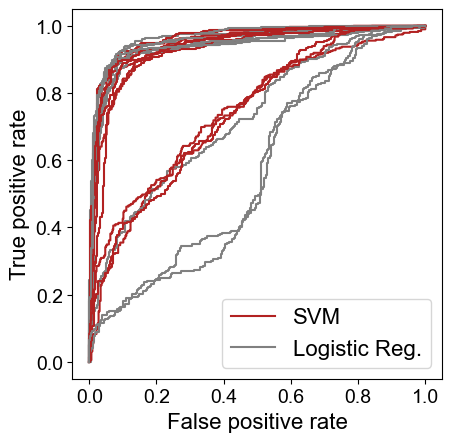

In [63]:
import matplotlib.pyplot as plt
from sklearn.metrics import auc
import numpy as np
from matplotlib import rcParams
from matplotlib import rc

plt.rcParams.update({'font.size': 16})
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14)
rc('font',**{'family':'sans-serif','sans-serif':['Arial']})

#Produce the ROC curves.
AUC_svm=np.zeros(len(lines))
AUC_log=np.zeros(len(lines))
fig, ax=plt.subplots()
ax.set_aspect('equal')
i=0
for test_line in lines:
    filename="SVM\\"+test_line+"_svm_auc.csv"
    data=np.genfromtxt(filename, delimiter=",")
    filename="SVM\\"+test_line+"_log_auc.csv"
    data_log=np.genfromtxt(filename, delimiter=",")
    if test_line=='Bima1':
        ax.plot(np.transpose(data)[0],np.transpose(data)[1], color='firebrick', label='SVM')
        ax.plot(np.transpose(data_log)[0],np.transpose(data_log)[1], color='gray', label='Logistic Reg.')
    else:
        ax.plot(np.transpose(data)[0],np.transpose(data)[1], color='firebrick')
        ax.plot(np.transpose(data_log)[0],np.transpose(data_log)[1], color='gray')
    AUC_svm[i]=sklearn.metrics.auc(np.transpose(data)[0],np.transpose(data)[1])
    AUC_log[i]=sklearn.metrics.auc(np.transpose(data_log)[0],np.transpose(data_log)[1])
    i+=1
ax.legend()
ax.set_xlabel("False positive rate")
ax.set_ylabel("True positive rate")
plt.savefig("Fig_S5D.png", format='png',bbox_inches='tight', dpi=300)


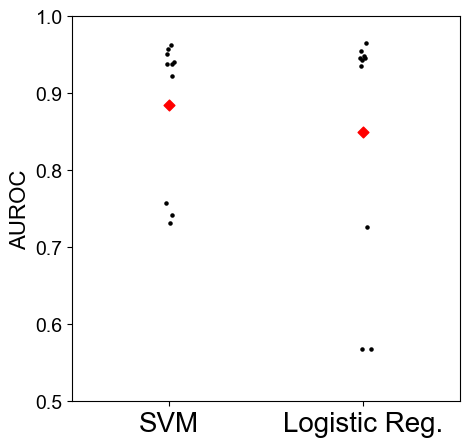

In [70]:
fig, ax=plt.subplots(figsize=(5,5))
plt.rc('xtick', labelsize=16) 

#Plot AUROCs
ax.scatter(np.zeros(10)+np.random.normal(0, 0.02,10), AUC_svm, color='black', s=5)
ax.scatter(np.zeros(1), np.mean(AUC_svm), color='red', marker="D", s=30)

ax.scatter(np.ones(10)+np.random.normal(0, 0.02,10), AUC_log, color='black', s=5)
ax.scatter(np.ones(1), np.mean(AUC_log), color='red', marker="D", s=30)
ax.set_ylabel("AUROC")
ax.set_xlim([-0.5,1.5])
ax.set_ylim([0.5,1.0])
ax.set_xticks([0,1],["SVM", "Logistic Reg."])
plt.savefig("Fig_S5E.png", format='png',bbox_inches='tight', dpi=300)


## Prediction by region of region space ##

In [16]:
LRCs=pd.read_csv('log-resc-coeffs.csv', index_col=0)


,geneid,n2K4_scale,n2K9_scale,n2K27_scale,n2ATAC_scale
0,ENSG00000002587,0.357262,-0.788293,0.181300,0.482320
1,ENSG00000003436,0.453714,-0.000000,-0.000000,0.717267
2,ENSG00000004948,0.718487,0.000000,0.000000,0.096537
3,ENSG00000005421,0.225795,-0.000000,0.000000,0.213652
4,ENSG00000006016,0.083651,0.000000,-0.605434,0.056739
...,...,...,...,...,...
707,ENSG00000278662,-0.000000,0.000000,-0.000000,0.000000
708,ENSG00000279656,-0.010923,0.000000,-0.000000,0.017872
709,ENSG00000279692,0.266833,-0.000000,-0.427339,0.399711
710,ENSG00000280143,-0.000000,-0.000000,0.000000,0.471231


In [60]:

lines = ["Bima1", "Kolf2", "Kolf3", "Kucg2", "Letw5", "Podx1", "Qolg1", "Sojd3", "Wibj2", "Yoch6"]
marks=['K9me3', 'K27me3', 'K4me3', 'K4me3','K4me3','ATAC', 'ATAC', 'ATAC']
annots=['gene', 'gene', 'gene', 'prompm1k','tx_pm1k','gene', 'prompm1k', 'tx_pm1k']
genelen=[1,1, 1, 0,0,1, 0, 0]
lengths=[0, 0, 0, 2000,2000,0, 2000, 2000]
epig_vars=['K4', 'K9', 'K27', 'ATAC']
accuracy=[]

#Run over different LRC restrictions to obtain the accuracies in SF5 C

#Cycle over all cell lines to test all of them from the other 9. Similar to the above cells.
for test_line in lines:
    training_lines=lines.copy()
    training_lines.remove(test_line)
    #Genes_set specifies the region of regulatory space we are assessing.
    genes_set=DE_genes['geneid'][(LRCs.n2K4_scale<0.2) & (LRCs.n2ATAC_scale<0.2) & (LRCs.n2K27_scale>-0.2)]
    DE_genes_set=DE_genes[DE_genes.geneid.isin(genes_set)]
    DE_genes_set=DE_genes_set.reset_index(drop=True)
    DE_bin_train, test_ground_truth=main_funcs.binarize_test(DE_genes_set,training_lines, test_line)
    genes_test=DE_genes.geneid[(LRCs.n2K4_scale<0.2) & (LRCs.n2ATAC_scale<0.2) & (LRCs.n2K27_scale>-0.2)]
    #Prepare data
    consolidate_data_glength('K9me3','gene', training_lines, 0)
    consolidate_data_glength('K27me3','gene', training_lines,0)
    consolidate_data_glength('K4me3','gene',training_lines, 0)
    consolidate_data('K4me3','prompm1k',training_lines, 2000)
    consolidate_data('K4me3','tx_pm1k',training_lines, 2000)
    consolidate_data_glength('ATAC','gene',training_lines, 0)
    consolidate_data('ATAC','prompm1k',training_lines, 2000)
    consolidate_data('ATAC','tx_pm1k', training_lines,2000)
    genes_test=consolidate_data_test(genes_test,marks,annots, test_line, genelen, lengths)
    genes_test['K4']=genes_test[['K4me3gene','K4me3prompm1k','K4me3tx_pm1k']].apply(max, axis=1)
    genes_test['ATAC']=genes_test[['ATACgene','ATACprompm1k','ATACtx_pm1k']].apply(max, axis=1)
    genes_test['K9']=genes_test['K9me3gene']
    genes_test['K27']=genes_test['K27me3gene']
    #Preparing the data for the SVM
    intensities_K4 = pd.read_csv('SVM/DE_genes_K4me3_geneSVM9.csv')
    intensities_K4_tx = pd.read_csv('SVM/DE_genes_K4me3_tx_pm1kSVM9.csv')
    intensities_K4_promoters = pd.read_csv('SVM/DE_genes_K4me3_prompm1kSVM9.csv')
    intensities_K4_pm1k = np.maximum(intensities_K4_tx, intensities_K4_promoters)
    intensities_K4 = np.maximum(intensities_K4, intensities_K4_pm1k)
    intensities_K4 = pd.DataFrame(intensities_K4, columns=intensities_K4.columns, index=intensities_K4.index)
    intensities_K9 = pd.read_csv('SVM/DE_genes_K9me3_geneSVM9.csv')
    intensities_K27 = pd.read_csv('SVM/DE_genes_K27me3_geneSVM9.csv')
    intensities_ATAC = pd.read_csv('SVM/DE_genes_ATAC_geneSVM9.csv')
    intensities_ATAC_tx = pd.read_csv('SVM/DE_genes_ATAC_tx_pm1kSVM9.csv')
    intensities_ATAC_promoters = pd.read_csv('SVM/DE_genes_ATAC_prompm1kSVM9.csv')
    intensities_ATAC_pm1k = np.maximum(intensities_ATAC_tx, intensities_ATAC_promoters)
    intensities_ATAC = np.maximum(intensities_ATAC, intensities_ATAC_pm1k)
    intensities_ATAC = pd.DataFrame(intensities_ATAC, columns=intensities_ATAC.columns, index=intensities_ATAC.index)
    vars = pd.DataFrame(columns=['geneid', 'line', 'K4', 'K9', 'K27', 'ATAC', 'expression'])
    for line in training_lines:
        for gene in genes_set:
            vars.loc[len(vars)] = [gene, line, intensities_K4.loc[intensities_K4['geneid'] == gene, line].values[0], 
                                   intensities_K9.loc[intensities_K9['geneid'] == gene, line].values[0], 
                                   intensities_K27.loc[intensities_K27['geneid'] == gene, line].values[0], 
                                   intensities_ATAC.loc[intensities_ATAC['geneid'] == gene, line].values[0], 
                                   DE_bin_train.loc[DE_bin_train['geneid'] == gene, line + '_binary'].values[0]]
    #SVM for prediction
    probs_prediction, prediction=main_funcs.SVM_prediction(genes_set, vars, genes_test, epig_vars)
    #ROC curve and save to file
    accuracy.append(sum(test_ground_truth.transcription.to_numpy(dtype=bool)==prediction)/len(genes_set))
    